In [195]:
# 临时计算，暂无逻辑
from datetime import datetime
from dateutil.relativedelta import relativedelta

import numpy as np
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei'] # 设置支持中文的字体
plt.rcParams['axes.unicode_minus'] = False # 正确显示负号

import akshare as ak
print(ak.__version__)


1.17.24


In [721]:

# 获取当前时间
current_date = datetime.now()
end_date = current_date.date()
start_date = end_date - relativedelta(years=1)

str_end = end_date.strftime("%Y%m%d")
str_start = start_date.strftime("%Y%m%d")

str_end, str_start


stock_code = "600497"

In [722]:
# 获取最近一年的复权行情
stock_zh_a_hist_df = ak.stock_zh_a_hist(symbol=stock_code, period="weekly", start_date=str_start, end_date=str_end, adjust="qfq")
print(stock_zh_a_hist_df.tail(3))

            日期    股票代码    开盘    收盘    最高    最低      成交量           成交额    振幅  \
50  2025-07-18  600497  5.46  5.49  5.53  5.34  3239917  1.761901e+09  3.49   
51  2025-07-25  600497  5.55  5.73  5.82  5.52  5798880  3.294103e+09  5.46   
52  2025-07-31  600497  5.72  5.47  5.89  5.46  4003931  2.270080e+09  7.50   

     涨跌幅   涨跌额    换手率  
50  0.92  0.05   6.43  
51  4.37  0.24  11.50  
52 -4.54 -0.26   7.94  


In [723]:
column_mapping = {
    '日期': 'date',
    '股票代码': 'stock_code',
    '开盘': 'open',
    '收盘': 'close',
    '最高': 'high',
    '最低': 'low',
    '成交量': 'volume',
    '成交额': 'amount',
    '振幅': 'amplitude',
    '涨跌幅': 'pct_change',
    '涨跌额': 'price_change',
    '换手率': 'turnover_rate'
}

stock_zh_a_hist_df = stock_zh_a_hist_df.rename(columns=column_mapping)

stock_zh_a_hist_df.tail(3)

,date,stock_code,open,close,high,low,volume,amount,amplitude,pct_change,price_change,turnover_rate
50,2025-07-18,600497,5.46,5.49,5.53,5.34,3239917,1.761901e+09,3.49,0.92,0.05,6.43
51,2025-07-25,600497,5.55,5.73,5.82,5.52,5798880,3.294103e+09,5.46,4.37,0.24,11.50
52,2025-07-31,600497,5.72,5.47,5.89,5.46,4003931,2.270080e+09,7.50,-4.54,-0.26,7.94


In [724]:
stock_zh_a_hist_df.index  = pd.to_datetime(stock_zh_a_hist_df.date)
stock_zh_a_hist_df.tail(3)

,date,stock_code,open,close,high,low,volume,amount,amplitude,pct_change,price_change,turnover_rate
date,,,,,,,,,,,,
2025-07-18,2025-07-18,600497,5.46,5.49,5.53,5.34,3239917,1.761901e+09,3.49,0.92,0.05,6.43
2025-07-25,2025-07-25,600497,5.55,5.73,5.82,5.52,5798880,3.294103e+09,5.46,4.37,0.24,11.50
2025-07-31,2025-07-31,600497,5.72,5.47,5.89,5.46,4003931,2.270080e+09,7.50,-4.54,-0.26,7.94


In [725]:
q1, q3 = np.percentile(stock_zh_a_hist_df['close'], [25, 75])

iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr

# 创建新DataFrame并保留索引
close_adjust_df = pd.DataFrame(index=stock_zh_a_hist_df.index)
close_adjust_df['close_adjust'] = np.clip(stock_zh_a_hist_df['close'], lower, upper)

In [726]:
# 假设x为时间序列索引，y为收盘价
x_data = close_adjust_df.index.astype(np.int64)
y_data = close_adjust_df['close_adjust']

In [727]:
# Savitzky-Golay滤波
window_size = 5 # window_length 必须为奇数
smoothed = savgol_filter(y_data, window_length=window_size, polyorder=3) 

# 样条插值（带凸性分析）
spline = UnivariateSpline(x_data, y_data, k=3, s=len(x_data))
spline_fit = spline(x_data)
second_deriv = spline.derivative(n=2)(x_data)  # 二阶导数

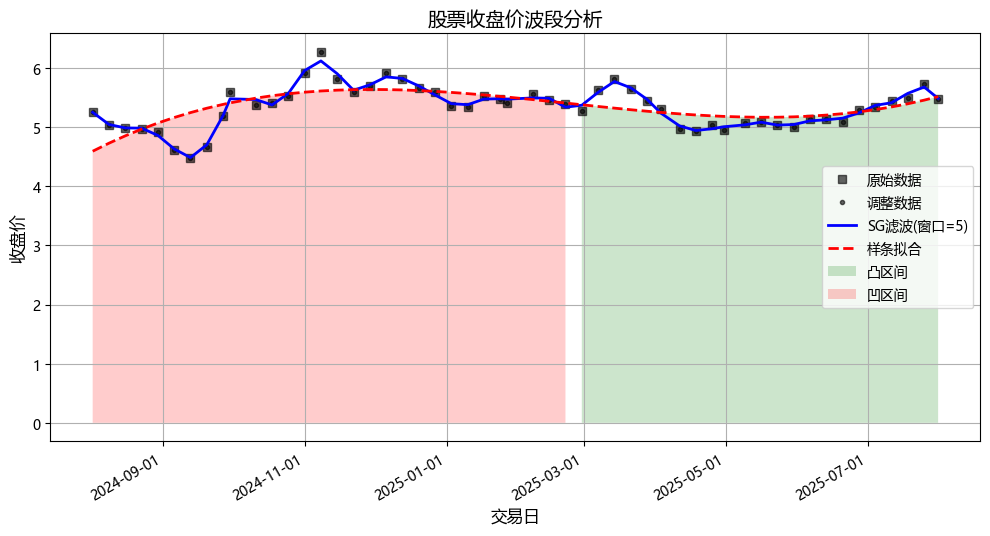

In [728]:
# 可视化
plt.figure(figsize=(12,6))
plt.plot(stock_zh_a_hist_df.index, stock_zh_a_hist_df['close'], 'ks', label='原始数据', alpha=0.6)
plt.plot(close_adjust_df.index, y_data, 'k.', label='调整数据', alpha=0.6)
plt.plot(close_adjust_df.index, smoothed, 'b-', label=f'SG滤波(窗口={window_size})', lw=2)
plt.plot(close_adjust_df.index, spline_fit, 'r--', label='样条拟合', lw=2)

# 标记凸性区域
plt.fill_between(close_adjust_df.index, spline_fit, where=second_deriv>0, 
                facecolor='green', alpha=0.2, label='凸区间')
plt.fill_between(close_adjust_df.index, spline_fit, where=second_deriv<0,
                facecolor='red', alpha=0.2, label='凹区间')

plt.title('股票收盘价波段分析', fontsize=14)
plt.xlabel('交易日', fontsize=12)
plt.ylabel('收盘价', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 设置日期格式
plt.gcf().autofmt_xdate()  # 自动旋转日期标签
plt.show()

In [729]:
second_deriv_df = pd.DataFrame(index=stock_zh_a_hist_df.index)
second_deriv_df['2deriv'] = second_deriv
second_deriv_df.tail(3)

,2deriv
date,
2025-07-18,2.276138e-32
2025-07-25,2.385580e-32
2025-07-31,2.479388e-32


In [730]:
# 标记负值区域
second_deriv_df['is_negative'] = second_deriv_df['2deriv'] < 0
# 找出区间变化点
second_deriv_df['group'] = (second_deriv_df['is_negative'] != second_deriv_df['is_negative'].shift(1)).cumsum()
# 筛选负值区间
negative_groups = second_deriv_df[second_deriv_df['is_negative']].groupby('group')

second_deriv_df.tail(3)

,2deriv,is_negative,group
date,,,
2025-07-18,2.276138e-32,False,2
2025-07-25,2.385580e-32,False,2
2025-07-31,2.479388e-32,False,2


In [731]:
filtered_df = second_deriv_df[(second_deriv_df['is_negative'] == True)]

# 获取最后三个分组号
last_three_groups = filtered_df['group'].unique()[-3:]

print(last_three_groups)

# 筛选条件
filtered_df = filtered_df[filtered_df['group'].isin(last_three_groups)]

filtered_df.head(3)

[1]


,2deriv,is_negative,group
date,,,
2024-08-02,-3.195970e-32,True,1
2024-08-09,-3.086528e-32,True,1
2024-08-16,-2.977085e-32,True,1


In [732]:
low_price = stock_zh_a_hist_df[stock_zh_a_hist_df.index.isin(filtered_df.index)].low.min()

low_df = stock_zh_a_hist_df[stock_zh_a_hist_df.low == low_price].head(1)

low_date_index = low_df.index[0]

print(f"周线日期 {low_date_index.strftime('%Y%m%d')} 为波段最低价，价格为 {low_price}")



周线日期 20240920 为波段最低价，价格为 4.37


In [733]:
high_df = stock_zh_a_hist_df[stock_zh_a_hist_df.index >= low_date_index]

high_price = high_df.high.max()

high_max_df = high_df[high_df.high == high_price].head(1)

high_date_index = high_max_df.index[0]

latest_high_price = stock_zh_a_hist_df[-2:].high.max()

print(f"日期 {high_date_index.strftime('%Y%m%d')} 为波段最高价，价格为 {high_price}")
print(f"近两周高价为{latest_high_price}")

日期 20241108 为波段最高价，价格为 6.79
近两周高价为5.89


In [734]:
gold_point = 0.618
win_point_pric = latest_high_price * 0.95
watch_point1_price = (high_price - low_price) * gold_point + low_price
watch_point2_price = (high_price - low_price) * (1 - gold_point) + low_price
print(f"止盈点价格为 {win_point_pric:.2f}")
print(f"观察点1价格为 {watch_point1_price:.2f}")
print(f"观察点2价格为 {watch_point2_price:.2f}")

止盈点价格为 5.60
观察点1价格为 5.87
观察点2价格为 5.29
